/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_49096/1649060519.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  accum = pd.concat([df_installs, df_uninstall], axis=1).fillna(method='ffill').fillna(0)


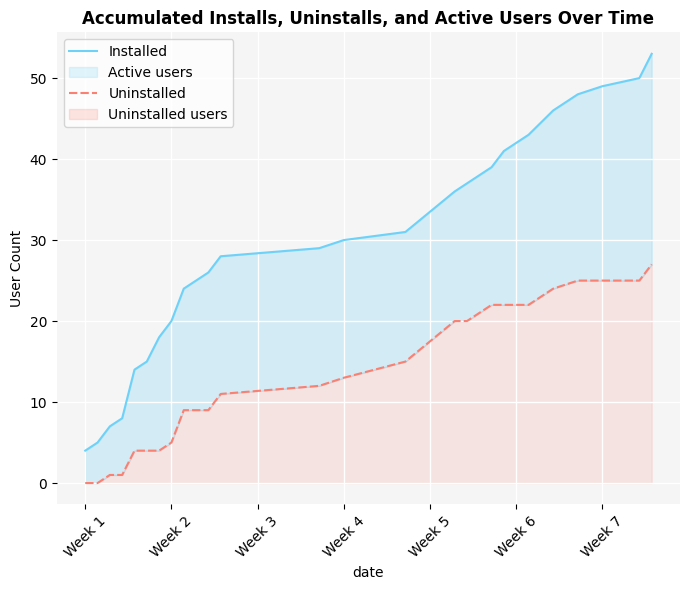

In [ ]:
# Enhanced Comparison Analysis - Checkout Visits, Pop-up Modal, and Purchase Events
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

# Load the CSV file
df = pd.read_csv('analytics.csv')


colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']

# Convert created_at to datetime (if not already)
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed', errors='coerce')
df = df[df['created_at'] <= pd.to_datetime('2025-05-26', utc=True)]
df['date'] = df['created_at'].dt.date

# Keep only the first event seen by every user (install event)
df_installs = df.sort_values('created_at').groupby('user_id', as_index=False).first()
df_installs['install'] = 1

# Get uninstall events
df_uninstall = df[df['type'] == 'uninstall'].copy().sort_values('created_at')
df_uninstall['uninstall'] = 1

df_installs = df_installs.groupby('date')['install'].sum().cumsum();
df_uninstall = df_uninstall.groupby('date')['uninstall'].sum().cumsum();

accum = pd.concat([df_installs, df_uninstall], axis=1).fillna(method='ffill').fillna(0)


import matplotlib.dates as mdates
# Convert dates to datetime for week calculation
dates = pd.to_datetime(df['date'])

# Calculate week number relative to the first date, then extend by one week
min_date = dates.min()
max_date = dates.max()
num_weeks = ((max_date - min_date).days // 7) + 1

# Extend by one additional week
extended_num_weeks = num_weeks + 1
extended_week_ends = [min_date + pd.Timedelta(days=7 * i) for i in range(extended_num_weeks + 1)]

# Plot
plt.figure(figsize=(7, 6))

# Set xticks at the start of each week, including the extra week
plt.xticks(
    extended_week_ends,
    [f"Week {i+1}" for i in range(extended_num_weeks + 1)],
    rotation=45
)
           
ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Plot the lines
sns.lineplot(data=accum, palette=['#6ED1F8', 'salmon'])

# Fill between installed and uninstalled (active users) with blue
ax.fill_between(accum.index, accum['install'], accum['uninstall'], 
                where=(accum['install'] > accum['uninstall']),
                color='#6ED1F8', alpha=0.25, label='Active Users')

# Fill below uninstalled with red
ax.fill_between(accum.index, 0, accum['uninstall'], 
                color='salmon', alpha=0.15, label='Uninstalled Users')
plt.title('Accumulated Installs, Uninstalls, and Active Users Over Time', fontweight='bold')
plt.ylabel('User Count')
plt.legend(['Installed', 'Active users', 'Uninstalled', 'Uninstalled users'], loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()